In [72]:
# import packages:
import numpy as np                   # Numeric Python
import matplotlib.pyplot as plt      # Plotting routines
import h5py                          # general HDF5 reading/writing library
import rioxarray as rx               # Package to read raster data from hdf5 files
from pyproj import Transformer, CRS  # libraries to allow coordinate transforms
import glob                          # Package to locate files on disk
import os                            # File-level utilities
import re                            # regular expressions for string interpretation
import icepyx as ipx                 # Package to interact with ICESat-2 online resources
from sliderule import icesat2        # Package for online ICESat-2 processing
import xarray as xr
import cartopy.crs as ccrs

In [73]:
#Please note: This tutorial is best run in interactive mode,
# but is archived with the interactive section disabled.
# To enable interactive mode, comment the next line, and uncomment the second line:
%matplotlib inline  
#%matplotlib widget 
%config InlineBackend.figure_format = 'retina'

ATL07 data download

References: 
ICESAT-2HackWeek-sea-ice-tutorials: https://github.com/ICESAT-2HackWeek/sea-ice-tutorials/blob/master/Notebooks/ATL07.ipynb
"Floes-are-Swell" project by Chris Horvat et al. https://github.com/ICESAT-2HackWeek/Floes-are-Swell
             

In [75]:
#set up our credentials to download the file
HOST = 'https://urs.earthdata.nasa.gov'
ipx.core.Earthdata.Earthdata('uwhackweek','hackweekadmin@gmail.com', HOST).login()

['Invalid username or password, please retry.']
['Invalid username or password, please retry.']


Please re-enter your Earthdata user ID:  shaker88
Earthdata Login password:  ·············


In [76]:
# Download (-nc = "no clobber" if it already exists
ds_url='https://n5eil01u.ecs.nsidc.org/ATLAS/ATL07.005/2019.09.25/ATL07-01_20190924235034_13580401_005_01.h5'
! wget -q -nc {ds_url} -O /tmp/ATL07_01_20190924235034_13580401_005_01.h5

In [77]:
#Read file
filepath = '/tmp/ATL07_01_20190924235034_13580401_005_01.h5'
f=h5py.File(filepath, 'r')

#check to see if it is forward (1)  or backward (0) orientation to know which beam is strong/weak
print(f['orbit_info/sc_orient'][0])

1


In [78]:
#Read coordinates and time variables
beam = 'gt1l'
lons = xr.DataArray(ATL07[beam+'/sea_ice_segments/longitude'][:],dims=['segs'])
lons.name='lons'
lats = xr.DataArray(ATL07[beam+'/sea_ice_segments/latitude'][:],dims=['segs'])
lats.name='lats'
lons360 = lons.where(lons.values>0, other=lons.values+360) #add 360 to lons less than 0

delta_time=ATL07[beam+'/sea_ice_segments/delta_time'][:] 
time = np.datetime64('2018-01-01') + (delta_time-86400*0.015).astype('timedelta64[s]' ) 
time

array(['2019-09-24T23:50:57', '2019-09-24T23:50:57',
       '2019-09-24T23:50:57', ..., '2019-09-24T23:55:45',
       '2019-09-24T23:55:45', '2019-09-24T23:55:45'],
      dtype='datetime64[s]')

In [80]:
#Read data
seg_dist = xr.DataArray(ATL07[beam+'/sea_ice_segments/seg_dist_x'][:],dims=['segs'])
seg_dist.name = 'seg_dist' 

height = xr.DataArray(ATL07[beam+'/sea_ice_segments/heights/height_segment_height'][:],dims=['segs'])
height.name = 'height'
height

<xarray.DataArray 'height' (segs: 72549)>
array([-0.23800814, -0.2380405 , -0.20599625, ..., -0.22319257,
       -0.20951055, -0.20943984], dtype=float32)
Dimensions without coordinates: segs

In [81]:
#Create a new xarray that has all necessary info 
ds=xr.merge([seg_dist, height])
ds.coords['lon'] = lons
ds.coords['lat'] = lats
ds.coords['time'] = xr.DataArray(time,dims=['segs'])
ds.coords['delta_time'] = xr.DataArray(delta_time,dims=['segs'])

ds.coords['lon360'] = lons360
ds.coords['segs'] = xr.DataArray(np.arange(0,len(height),1),dims=['segs'])
ds

<xarray.Dataset>
Dimensions:     (segs: 72549)
Coordinates:
    lon         (segs) float64 -35.97 -35.98 -36.04 -36.04 ... 170.9 170.9 170.9
    lat         (segs) float64 83.78 83.78 83.8 83.8 ... 77.47 77.47 77.47 77.47
    time        (segs) datetime64[ns] 2019-09-24T23:50:57 ... 2019-09-24T23:5...
    delta_time  (segs) float64 5.461e+07 5.461e+07 ... 5.461e+07 5.461e+07
    lon360      (segs) float64 324.0 324.0 324.0 324.0 ... 170.9 170.9 170.9
  * segs        (segs) int64 0 1 2 3 4 5 ... 72543 72544 72545 72546 72547 72548
Data variables:
    seg_dist    (segs) float64 9.378e+06 9.378e+06 ... 1.142e+07 1.142e+07
    height      (segs) float32 -0.238 -0.238 -0.206 ... -0.2232 -0.2095 -0.2094

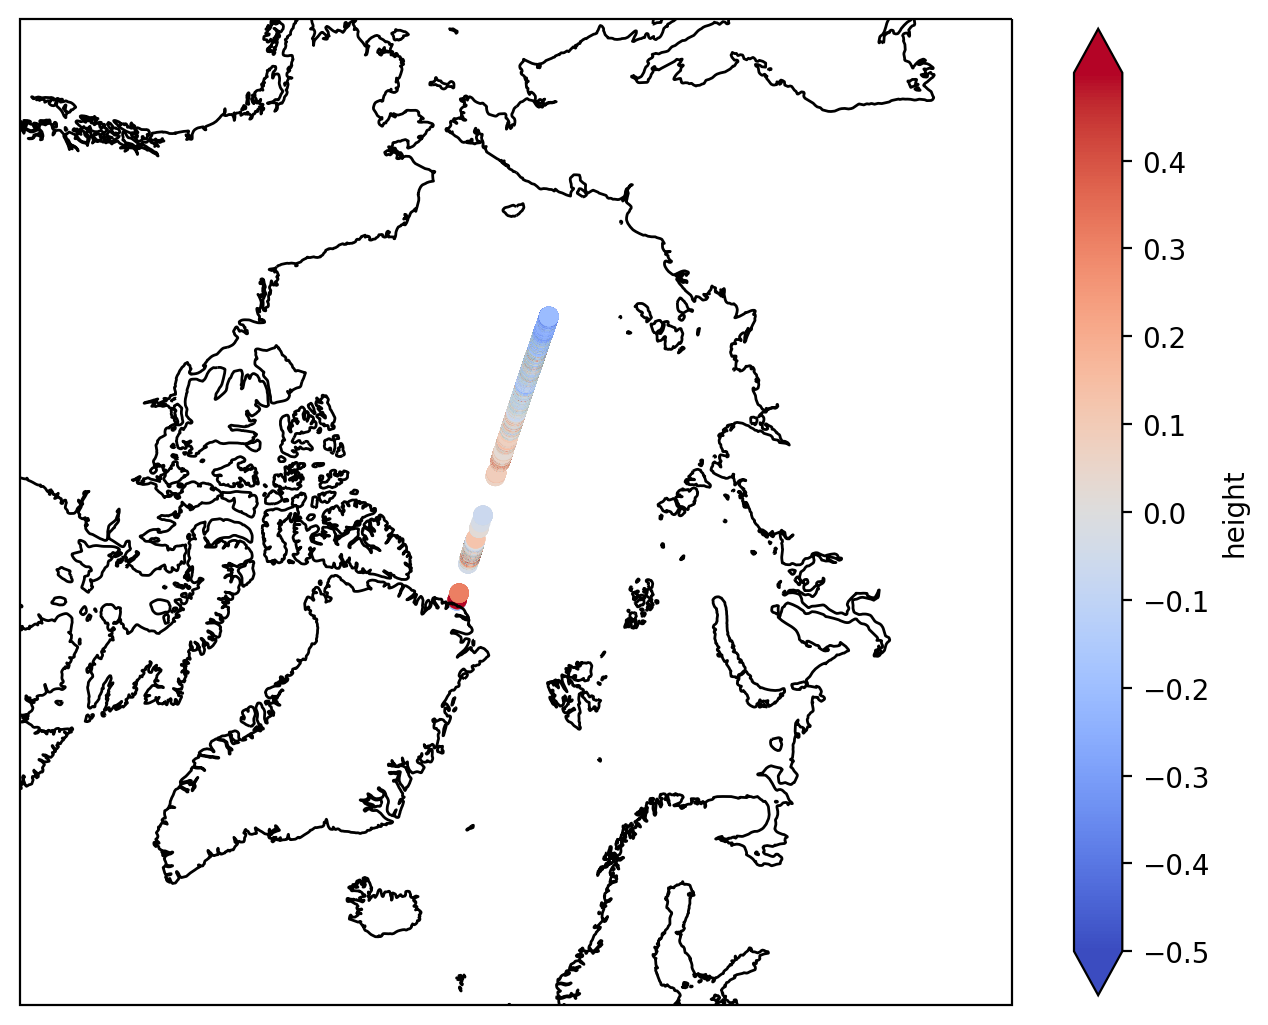

In [92]:
#Plot along-track height data
vmin=-0.5
vmax=0.5
ticks=np.arange(vmin,vmax,0.1)

plt.figure(figsize=(8,8), dpi= 100)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-180,180,60,90], ccrs.PlateCarree())  # minlon, minlat, maxlon, maxlat
plt.scatter(ds['lon'][:], ds['lat'][:],c=ds['height'][:], cmap=plt.cm.get_cmap('coolwarm'), vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label='height', shrink=0.8, ticks=ticks,extend='both');

In [65]:
extent=np.array([np.min(ds['lon']), np.max(ds['lon']), np.min(ds['lat']), np.max(ds['lat'])])
extent

array([-179.99906949,  179.99886618,   77.46806344,   87.97359497])

In [90]:
print(np.max(ds['height']))
print(np.min(ds['height']))

<xarray.DataArray 'height' ()>
array(3.4028235e+38, dtype=float32)
<xarray.DataArray 'height' ()>
array(-0.41270024, dtype=float32)
